In [159]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import ffmpeg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers


In [10]:
dataSet_path = "C:/Users/bipls/Desktop/Learnings/Projects/GenreNet/dataset/data/genres_original"
genres = os.listdir(dataSet_path)
print(genres)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [11]:
for g in genres:
    path = os.path.join(dataSet_path, g)
    print(g, ":", len([f for f in os.listdir(path) if f.endswith(".wav")]))

blues : 100
classical : 100
country : 100
disco : 100
hiphop : 100
jazz : 100
metal : 100
pop : 100
reggae : 100
rock : 100


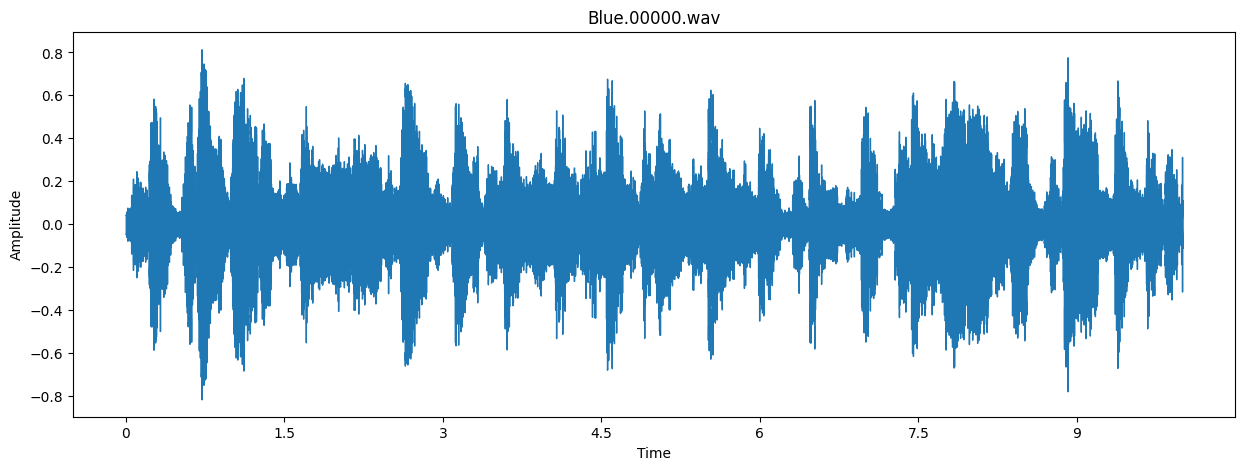

In [ ]:
# Plotting the waveform of a sample audio file
file_path = os.path.join(dataSet_path, "blues", "blueS.00000.wav")
signal ,sr = librosa.load(file_path, duration=10)

plt.figure(figsize=(15, 5))
librosa.display.waveshow(signal, sr=sr)
plt.title("Blue.00000.wav")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

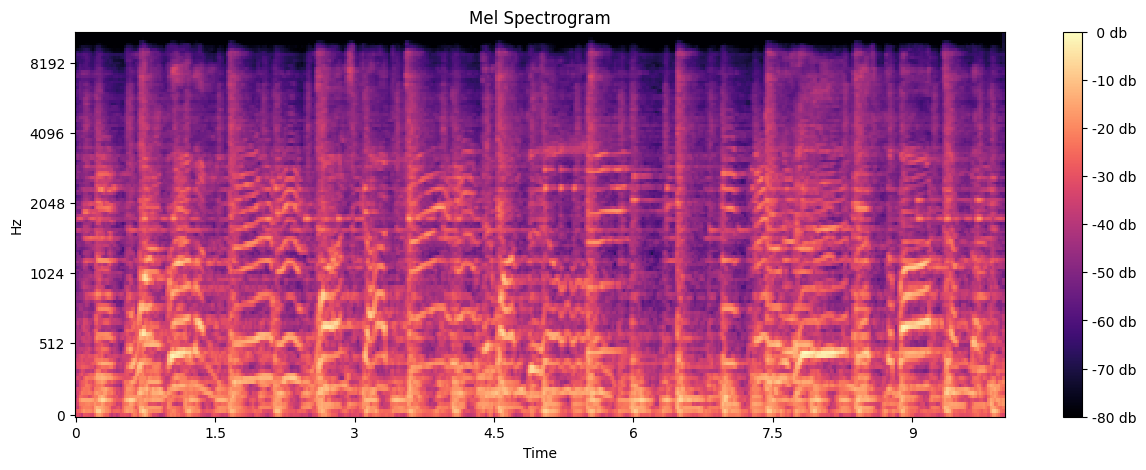

In [17]:
#Converts the audio waveform into a Mel spectrogram, which is like a 2D map of frequency vs time
mel_spect =librosa.feature.melspectrogram(y=signal, sr=sr)

#Convert to Log Scale (dB)
mel_spect= librosa.power_to_db(mel_spect, ref=np.max)

#plt this spectogram
plt.figure(figsize=(15, 5))
plt.title("Mel Spectrogram")
librosa.display.specshow(mel_spect, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%2.0f db")
plt.title("Mel Spectrogram")
plt.show()


In [32]:
#classic ML

#function to extract MFCCs
def extract_mfcc(file_path,n_mfcc=13):
    signal, sr= librosa.load(file_path, duration=10)
    mfcc= librosa.feature.mfcc(y=signal, sr=sr,n_mfcc= n_mfcc)
    mfcc_mean= np.mean(mfcc.T, axis=0)  #taking the mean across time axis
    return mfcc_mean


#example
mfcc= extract_mfcc(file_path)
print(mfcc.shape)

(13,)


In [40]:
#safe load (to handle corrupted files)
def safe_load(file_path, duration=30):
    """
    Tries to load audio file. Returns None if fails.
    """
    try:
        signal, sr = librosa.load(file_path, sr=None, duration=duration, mono=True)
        return signal, sr
    except Exception as e:
        print(f"Skipping file {file_path}, error: {e}")
        return None, None

In [225]:
#Data Augmentation
def augment_audio(signal, sr):
    # Pitch shift
    pitch_signal = librosa.effects.pitch_shift(y=signal, sr=sr, n_steps=np.random.uniform(-3, 3))

    if np.random.rand()>0.5:
        rate= np.random.uniform(0.8, 1.3)
        stretched_signal = librosa.effects.time_stretch(y=signal, rate= rate)
    else:
        stretched_signal = signal  # fallback to original

    return [signal, pitch_signal,stretched_signal]

"""  
  # Time stretch
    
    # Add noise
    noise_signal = signal + 0.005*np.random.randn(len(signal))
"""


'  \n  # Time stretch\n    \n    # Add noise\n    noise_signal = signal + 0.005*np.random.randn(len(signal))\n'

In [226]:

#Prepare Dataset
X, y = [], []
skipped_files = []

#Loop over genres and files
for genre in genres:
    genre_path = os.path.join(dataSet_path, genre)
    for file in os.listdir(genre_path):
        if file.endswith(".wav"):
            audio_path = os.path.join(genre_path, file)
            
            #exception to handle corrupted file
            try:
                signal, sr = librosa.load(audio_path, duration=30)
                if signal.size == 0:
                    print(f"Skipping empty file: {audio_path}")
                    skipped_files.append(file)
                    continue
            except Exception as e:
                print(f"Skipping file {audio_path} due to error: {e}")
                skipped_files.append(file)
                continue
            
            augmented_signals = augment_audio(signal, sr)

            for aug_signal in augmented_signals:
                # Convert to log-mel spectrogram
                mel_spec = librosa.feature.melspectrogram(y=aug_signal, sr=sr, n_mels=128)
                log_mel = librosa.power_to_db(mel_spec, ref=np.max)
                if log_mel.shape[1] < 128:
                    log_mel = np.pad(log_mel, ((0,0),(0,128-log_mel.shape[1])), mode='constant')
                else:
                    log_mel = log_mel[:, :128]


                X.append(log_mel)
                y.append(genre)

                """
            if log_mel.shape[1] < 128:
                log_mel = np.pad(log_mel, ((0,0),(0,128-log_mel.shape[1])), mode='constant')
            else:
                log_mel = log_mel[:, :128]
            """

C:\Users\bipls\AppData\Local\Temp\ipykernel_12132\331074848.py:14: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(audio_path, duration=30)
c:\Users\bipls\conda2.6\envs\genrenet\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping file C:/Users/bipls/Desktop/Learnings/Projects/GenreNet/dataset/data/genres_original\jazz\jazz.00054.wav due to error: 


In [227]:
#Normalize Spectrograms
X= np.array(X)
X = X.reshape(-1, 128, 128, 1).astype('float32')
# Normalize to 0-1
X = (X - X.min()) / (X.max() - X.min())
y=np.array(y)

#Label Encoding and One-Hot Encoding
le= LabelEncoder()
y_encoded= le.fit_transform(y)
y_catagorical= to_categorical(y_encoded)

print(X.shape, y_catagorical.shape)
print(np.unique(y_encoded, return_counts=True))

(2997, 128, 128, 1) (2997, 10)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([300, 300, 300, 300, 300, 297, 300, 300, 300, 300]))


In [196]:
print(X.shape, y_encoded.shape)

(999, 128, 128, 1) (999,)


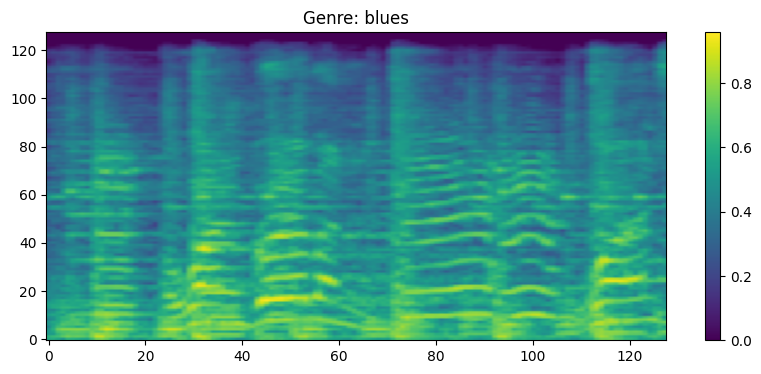

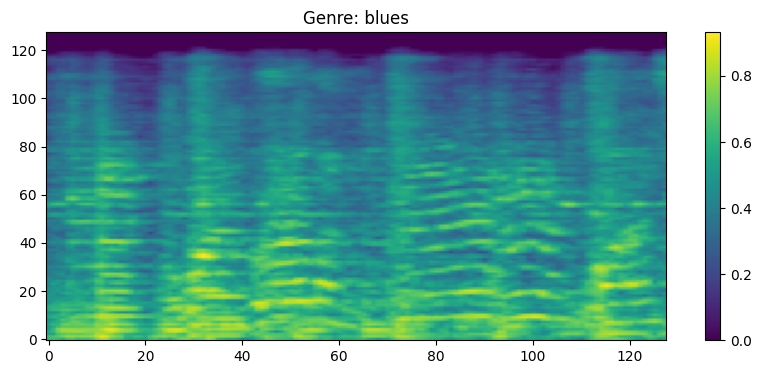

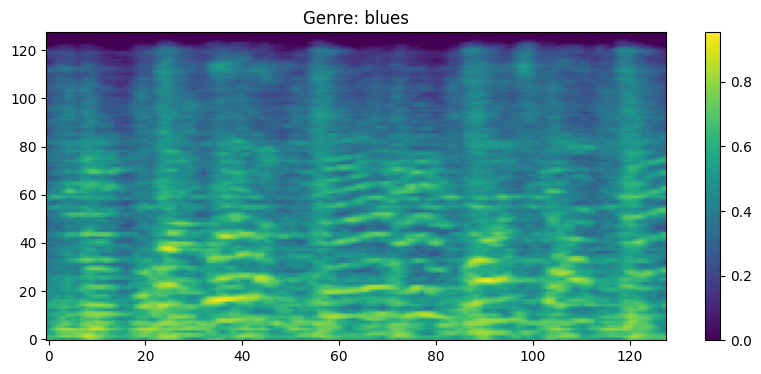

In [228]:
# Visualize some samples
for i in range(3):
    plt.figure(figsize=(10, 4))
    plt.title(f"Genre: {le.inverse_transform([np.argmax(y[i])])[0]}")
    plt.imshow(X[i].squeeze(), aspect="auto", origin="lower", cmap="viridis")
    plt.colorbar()
    plt.show()

In [229]:
#train_test_split
X_train,X_test,y_Train,y_test = train_test_split(X,y_catagorical, test_size=0.3, random_state=42, stratify=y_encoded)


In [234]:
#Model Training
model= Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(128,128,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu", input_shape=(128,128,1)),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu", input_shape=(128,128,1)),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation="relu", input_shape=(128,128,1)),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(len(genres), activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_77 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,569,034 (5.99 MB)

 Trainable params: 1,568,970 (5.99 MB)

 Non-trainable params: 64 (256.00 B)

In [235]:
early_stoping= EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)



history= model.fit(X_train, y_Train,
                   validation_split=0.2,
                   epochs=100,
                   batch_size=32,
                   callbacks=[early_stoping])

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 336ms/step - accuracy: 0.1717 - loss: 2.2317 - val_accuracy: 0.1238 - val_loss: 2.2868
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 311ms/step - accuracy: 0.2946 - loss: 1.9390 - val_accuracy: 0.1429 - val_loss: 2.2335
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 305ms/step - accuracy: 0.3584 - loss: 1.7563 - val_accuracy: 0.1690 - val_loss: 2.2081
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 312ms/step - accuracy: 0.4192 - loss: 1.6003 - val_accuracy: 0.2238 - val_loss: 2.1162
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 309ms/step - accuracy: 0.4514 - loss: 1.5127 - val_accuracy: 0.4357 - val_loss: 2.0078
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 334ms/step - accuracy: 0.4961 - loss: 1.4208 - val_accuracy: 0.3976 - val_loss: 1.9918
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 317ms/step - accuracy: 0.5325 - loss: 1.3275 - val_accuracy: 0.4429 - val_loss: 1.7545
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 313ms/step - accuracy: 0.5742 - loss: 1.1985 - 

In [236]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}% /n Test Loss: {test_loss:.2f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7789 - loss: 0.7266
Test Accuracy: 77.89% /n Test Loss: 0.73


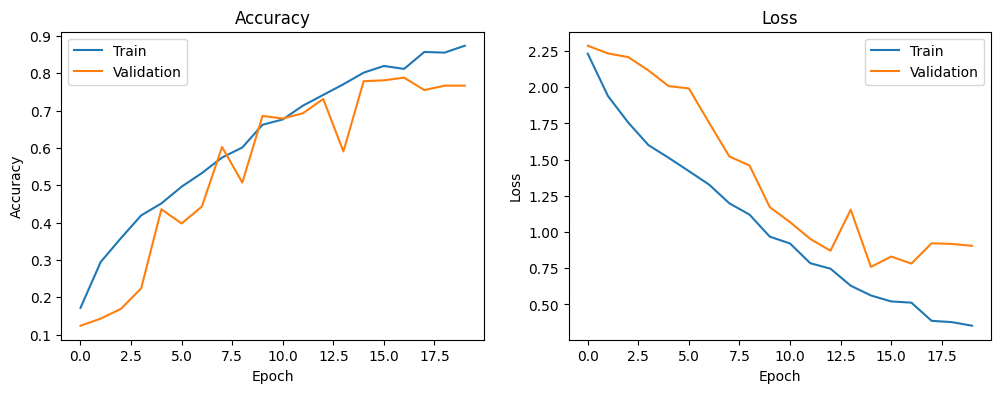

In [237]:


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
